In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.layers import Dense, Input, GlobalMaxPooling1D,LSTM
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import Model
from keras import regularizers

In [3]:
train_data=pd.read_csv('../input/quora-record-linkage/quora_train.csv').dropna()
test_data=pd.read_csv('../input/quora-record-linkage/quora_test.csv').dropna()

In [4]:
val_data=train_data.sample(frac=0.2,random_state=7)
train_data=train_data.drop(val_data.index)

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [7]:
NUM_WORDS=30522
tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                      lower=True)
tokenizer.fit_on_texts(train_data.question1+' '+train_data.question2)
sequences1_train = tokenizer.texts_to_sequences(train_data.question1)
sequences2_train = tokenizer.texts_to_sequences(train_data.question2)
sequences1_valid=tokenizer.texts_to_sequences(val_data.question1)
sequences2_valid=tokenizer.texts_to_sequences(val_data.question2)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 72738 unique tokens.


In [9]:
X1_train = pad_sequences(sequences1_train,maxlen=32)
X2_train = pad_sequences(sequences2_train,maxlen=32)
X1_val = pad_sequences(sequences1_valid,maxlen=32)
X2_val = pad_sequences(sequences2_valid,maxlen=32)
y_train = train_data.is_duplicate
y_val = val_data.is_duplicate
print('Shape of X train and X validation tensor:', X1_train.shape,X1_val.shape)
print('Shape of label train and validation tensor:', y_train.shape,y_val.shape)

Shape of X train and X validation tensor: (258782, 32) (64696, 32)
Shape of label train and validation tensor: (258782,) (64696,)


In [10]:
!brew install wget

!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

/bin/sh: 1: brew: not found
--2020-11-09 23:24:10--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.66.190
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.66.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  35.1MB/s    in 47s     

2020-11-09 23:24:57 (33.6 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [11]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,NUM_WORDS)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

In [12]:
AUTO = tf.data.experimental.AUTOTUNE

# Create strategy from tpu
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

# Data access
#GCS_DS_PATH = KaggleDatasets().get_gcs_path('kaggle/input/') 

In [13]:
sequence_length = X1_train.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.5

def build_cnn_model(embedding_layer,sequence_length):
    inputs1 = Input(shape=(sequence_length,))
    inputs2 = Input(shape=(sequence_length,))
    embedding1 = embedding_layer(inputs1)
    embedding2 = embedding_layer(inputs2)
    reshape1 = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding1)
    reshape2 = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding2)

    conv_0_layer = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))
    conv_1_layer = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))
    conv_2_layer = Conv2D(num_filters, (filter_sizes[2], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))

    maxpool_0_layer = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))
    maxpool_1_layer = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))
    maxpool_2_layer = MaxPooling2D((sequence_length - filter_sizes[2] + 1, 1), strides=(1,1))

    conv1_0 = conv_0_layer(reshape1)
    maxpool1_0=maxpool_0_layer(conv1_0)
    conv1_1 = conv_1_layer(reshape1)
    maxpool1_1=maxpool_1_layer(conv1_1)
    conv1_2 = conv_2_layer(reshape1)
    maxpool1_2=maxpool_2_layer(conv1_2)

    conv2_0 = conv_0_layer(reshape2)
    maxpool2_0=maxpool_0_layer(conv2_0)
    conv2_1 = conv_1_layer(reshape2)
    maxpool2_1=maxpool_1_layer(conv2_1)
    conv2_2 = conv_2_layer(reshape2)
    maxpool2_2=maxpool_2_layer(conv2_2)

    merged_tensor1 = concatenate([maxpool1_0, maxpool1_1, maxpool1_2], axis=1)
    flatten1 = Flatten()(merged_tensor1)
    out1 = Reshape((3*num_filters,))(flatten1)

    merged_tensor2 = concatenate([maxpool2_0, maxpool2_1, maxpool2_2], axis=1)
    flatten2 = Flatten()(merged_tensor2)
    out2 = Reshape((3*num_filters,))(flatten2)

    merge = concatenate([flatten1,flatten2])
    output = Dense(units=1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01))(merge)

    # this creates a model that includes
    model = Model([inputs1,inputs2], output)
    adam = Adam(lr=1e-3)

    model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=[tf.keras.metrics.AUC()])
    callbacks = [EarlyStopping(monitor='val_loss',patience=3)]
    return model

In [14]:
def build_lstm_model(embedding_layer,MAX_SEQUENCE_LENGTH):
    lstm_layer = LSTM(256, dropout=0.1, recurrent_dropout=0.1)

    sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_1 = embedding_layer(sequence_1_input)
    x1 = lstm_layer(embedded_sequences_1)

    sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_2 = embedding_layer(sequence_2_input)
    y1 = lstm_layer(embedded_sequences_2)

    merged = concatenate([x1, y1])
    merged = Dropout(0.1)(merged)
    merged = BatchNormalization()(merged)

    merged = Dense(128, activation='relu')(merged)
    merged = Dropout(0.1)(merged)
    merged = BatchNormalization()(merged)

    preds = Dense(1, activation='sigmoid')(merged)
    
    model = Model(inputs=[sequence_1_input, sequence_2_input],outputs=preds)
    adam = Adam(lr=1e-3)
    model.compile(loss='binary_crossentropy',
        optimizer=adam,
        metrics=[tf.keras.metrics.AUC()])
    return model

In [15]:
with strategy.scope():
    model = build_lstm_model(embedding_layer,sequence_length)

In [ ]:
model.summary()

In [16]:
model.fit([X1_train,X2_train], y_train, batch_size=1000, epochs=5, verbose=1, validation_data=([X1_val,X2_val],y_val))

Epoch 1/5
259/259 [==============================] - 15s 58ms/step - auc: 0.7896 - loss: 0.5319 - val_auc: 0.8519 - val_loss: 0.5228
Epoch 2/5
259/259 [==============================] - 8s 32ms/step - auc: 0.8765 - loss: 0.4216 - val_auc: 0.8828 - val_loss: 0.4246
Epoch 3/5
259/259 [==============================] - 8s 32ms/step - auc: 0.9127 - loss: 0.3599 - val_auc: 0.8932 - val_loss: 0.3970
Epoch 4/5
259/259 [==============================] - 8s 32ms/step - auc: 0.9375 - loss: 0.3070 - val_auc: 0.9007 - val_loss: 0.3961
Epoch 5/5
259/259 [==============================] - 8s 32ms/step - auc: 0.9541 - loss: 0.2641 - val_auc: 0.9023 - val_loss: 0.4141


In [17]:
model.save_weights('word2vec_lstm.h5')

In [ ]:
model.load_weights('word2vec_lstm.h5')

In [ ]:
model.fit([X1_train,X2_train], y_train, batch_size=1000, epochs=1, verbose=1, validation_data=([X1_val,X2_val],y_val))

In [36]:
sequences1_test=tokenizer.texts_to_sequences(test_data.question1)
sequences2_test=tokenizer.texts_to_sequences(test_data.question2.astype(str))
X1_test = pad_sequences(sequences1_test,maxlen=X1_train.shape[1])
X2_test = pad_sequences(sequences2_test,maxlen=X1_train.shape[1])
y_score=model.predict([X1_test,X2_test])

In [19]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

import matplotlib.pyplot as plt

In [30]:
y_test=test_data.is_duplicate.values
model.evaluate([X1_test,X2_test],y_test)

1109/2528 [============>.................] - ETA: 16s - auc: 0.9054 - loss: 0.4073

KeyboardInterrupt: 

In [38]:
y_score=y_score[:80870]

Text(0.5, 1.0, 'Precision-Recall curve: AP=0.85')

<Figure size 432x288 with 0 Axes>

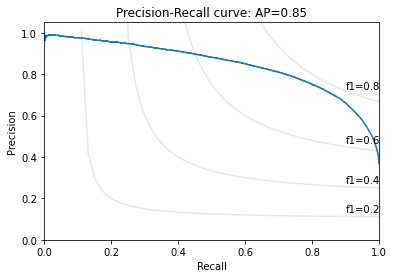

In [39]:
precision, recall, f1=precision_recall_curve(y_test,y_score)
average_precision = average_precision_score(y_test, y_score,average="micro")

plt.clf()
plt.figure()
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
plt.step(recall,precision,where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Precision-Recall curve: AP={0:0.2f}'
    .format(average_precision))